In [47]:
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples, noise=0.05, random_state=42)
print(X)
# print(y)

[[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 ...
 [-0.12823057 -0.82613318]
 [ 0.66090453 -0.79319015]
 [ 0.27841491  0.96735953]]


In [48]:
import pandas as pd
circle_df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], 'label': y})
circle_df.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


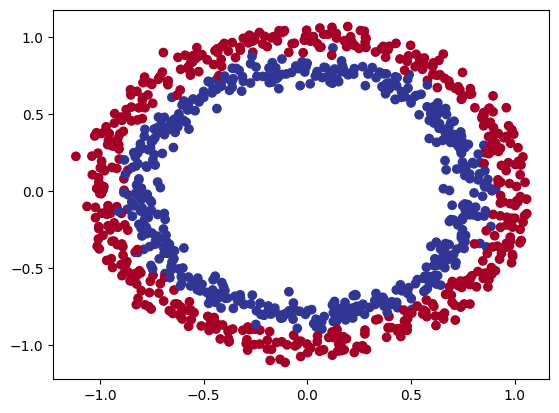

In [49]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [50]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [51]:
print(X)
print(y)

tensor([[ 0.7422,  0.2467],
        [-0.7340,  0.1687],
        [-0.8299,  0.2220],
        ...,
        [-0.1282, -0.8261],
        [ 0.6609, -0.7932],
        [ 0.2784,  0.9674]])
tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 1., 0.

In [52]:
# splitting data into training, testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.2  # 80% training, 20% testing
                                                    )

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

800
200
800
200


In [53]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


**Building Model for non-linearity**

In [54]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2, out_features=10)
        self.layer_2=nn.Linear(in_features=10, out_features=10)
        self.layer_3=nn.Linear(in_features=10, out_features=1)
        self.relu=nn.ReLU() #ReLU activation function (non-linear activation function)

    def forward(self,x):
        # return self.layer_3(self.layer_2(self.layer_1(x)))
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2=CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [55]:
# loss function, optimizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [56]:
# accuracy function
# accuracy between `true` and `predicted` value
def accuracy_fn(y_true, y_pred):
    correct=torch.eq(y_true, y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

**Training Model with non-linearity**

In [57]:
torch.manual_seed(42)
epochs=1000

# put all the data on target device
X_train, y_train=X_train.to(device), y_train.to(device)
X_test, y_test=X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # Training Loop
    model_2.train()

    # forward pass
    y_logits=model_2(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    # loss function, accuracy
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss(): work with `raw logits`, calculate loss between `predicted` and `actual` value
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    # zerograd optimization
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # updation
    optimizer.step()

    # Testing Loop
    model_2.eval()
    with torch.inference_mode():
        # forward pass
        test_logits=model_2(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        # loss, accuracy
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch%100==0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")





Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69329, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69117, Accuracy: 52.75% | Test Loss: 0.69126, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68978, Accuracy: 54.25% | Test Loss: 0.68976, Test Accuracy: 54.50%
Epoch: 300 | Loss: 0.68790, Accuracy: 52.88% | Test Loss: 0.68774, Test Accuracy: 55.00%
Epoch: 400 | Loss: 0.68530, Accuracy: 52.88% | Test Loss: 0.68492, Test Accuracy: 55.00%
Epoch: 500 | Loss: 0.68126, Accuracy: 53.62% | Test Loss: 0.68084, Test Accuracy: 56.00%
Epoch: 600 | Loss: 0.67545, Accuracy: 54.50% | Test Loss: 0.67503, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66726, Accuracy: 58.00% | Test Loss: 0.66680, Test Accuracy: 57.50%
Epoch: 800 | Loss: 0.65355, Accuracy: 63.50% | Test Loss: 0.65369, Test Accuracy: 68.00%
Epoch: 900 | Loss: 0.62686, Accuracy: 72.62% | Test Loss: 0.63023, Test Accuracy: 74.50%


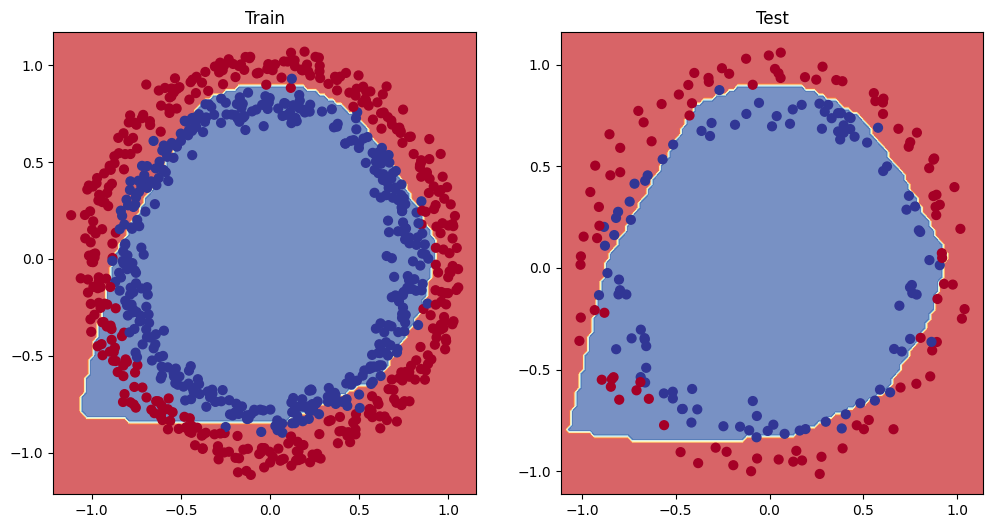

In [59]:
# plotting using `plot_decision_boundary`
from helper_functions import plot_decision_boundary
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_2,X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_2,X_test, y_test)

# accuracy is much more better